# <center> Trabajo Practico 2 </center>
### <center> Grupo 10 </center>
## Integrantes:
#### Alan Richmond
#### Flavian Ferré


# Importaciones

## Algunas instalaciones

A ejecutar solo si no dispone de los paquetes necesarios

In [1]:
!pip install stop_words

In [2]:
!pip install es_core_news_sm

## Librerias

In [3]:
import datetime
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import spacy
import stop_words
import tensorflow as tf

from tensorflow import keras

from keras import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Embedding, Input, LSTM, TextVectorization
from keras.metrics import F1Score
from keras.models import load_model
from keras.optimizers import Adadelta, Adam, RMSprop
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, make_scorer, precision_score, recall_score
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

## Conjuntos

In [4]:
# Cargar los datasets del Kaggle
conjunto_train = pd.read_csv('Datasets/train.csv')
conjunto_test = pd.read_csv('Datasets/test.csv')
sample_solution = pd.read_csv('Datasets/sample_solution.csv')

# StopWords que va a servir a lematizar
stop_words_es = stop_words.get_stop_words('es')

## Train_test_split

No se debe ejecutar de nuevo

In [5]:
# Dividir los conjuntos
X = conjunto_train['review_es']
y = conjunto_train['sentimiento'].map({'positivo': 1, 'negativo': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Exportacion de esos nuevos conjuntos
X_train.to_csv('Datasets/X_train.csv')
X_test.to_csv('Datasets/X_test.csv')
y_train.to_csv('Datasets/y_train.csv')
y_test.to_csv('Datasets/y_test.csv')

## Lematizacion

No se debe ejecutar de nuevo

In [25]:
# Transformacion del conjunto test
test = conjunto_test.set_index('ID')
test.index.name = None
test = test['review_es']
test

60000    La mayor virtud de esta película es su existen...
60001    No soy un experto cinéfilo, pero pocas veces m...
60002    Si no eres un incondicional del humor estilo T...
60003    No sé qué está pasando, si la gente se deja ll...
60004    Pero cuando amanece,y me quedo solo,siento en ...
                               ...                        
68594    Buena no, lo siguiente. Por fin un film serio ...
68595    Me esperaba mucho, pero que mucho, más.Guión m...
68596    De mal cuerpo como sensación al finalizar, de ...
68597    Los que han añadido comentarios os lo han dich...
68598    Fui a ver esta película de cine con entusiasmo...
Name: review_es, Length: 8599, dtype: object

In [26]:
# Lematizacion
nlp = spacy.load('es_core_news_sm')

def preprocess_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if token.is_alpha])

# Exportaciones
conjunto_test_processed = test.apply(preprocess_text)
X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)
conjunto_test_processed.to_csv('Datasets/conjunto_test_processed.csv')
X_train_processed.to_csv('Datasets/X_train_processed.csv')
X_test_processed.to_csv('Datasets/X_test_processed.csv')

# 1. Bayes Naïve

## Importaciones

In [ ]:
# Datasets a cargar
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

# Esos son los que fueron lematizados
X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

## Vectorizacion de las críticas

Vamos a hacer diferentes vectorizaciones para elegir la mejor :
- Vect_1 : TFIDF Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_2 : TFIDF Vectorizer con lemmarizacion y con hiperparametros afinados
- Vect_3 : Count Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_4 : Count Vectorizer con lemmarizacion y con hiperparametros afinados

In [85]:
best_configs = []

# Creacion de las diferentes combinaciones de hiperparametros
min_dfs = [1, 2, 3, 4, 5, 8, 10, 15]
ngram_ranges = [(1, 2), (1, 3), (1, 4)]
configs = [{'min_df': min_df, 'ngram_range': ngram_range} for min_df in min_dfs for ngram_range in ngram_ranges]

# Model de referencia para encontrar la vectorizacion optimizada
nb_old_model = joblib.load('Modelos/bn_model_2024-06-12.joblib')

def test_config(config, X_train, vectorizer):
    vect = vectorizer(stop_words=stop_words_es, **config)
    X_train_vect = vect.fit_transform(X_train)

    # Aca tenemos problemas con ese parametro cuando cargamos el modelo, asi ponemos True cada vez
    if hasattr(nb_old_model, 'force_alpha') and nb_old_model.force_alpha not in [True, False]:
        nb_old_model.force_alpha = True
    
    score = cross_val_score(nb_old_model, X_train_vect, y_train, cv=10, scoring='f1_macro')
    return round(score.mean(), 6)

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultinomialNB from version 1.2.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Vect_1

In [86]:
best_score_1 = 0
best_config_1 = None

for config in configs:
    score = test_config(config, X_train, TfidfVectorizer)
    if score > best_score_1:
        best_score_1 = score
        best_config_1 = config

best_configs.append([best_score_1, best_config_1, False, "TFIDF"])

print("Mejor config Vect_1 :", best_config_1)
print("Mejor F1-Score Vect_1 :", best_score_1)

Mejor config Vect_1 : {'min_df': 2, 'ngram_range': (1, 3)}
Mejor F1-Score Vect_1 : 0.886926


### Vect_2

In [87]:
best_score_2 = 0
best_config_2 = None

for config in configs:
    score = test_config(config, X_train_processed, TfidfVectorizer)
    if score > best_score_2:
        best_score_2 = score
        best_config_2 = config

best_configs.append([best_score_2, best_config_2, True, "TFIDF"])

print("Mejor config Vect_2 :", best_config_2)
print("Mejor F1-Score Vect_2 :", best_score_2)

Mejor config Vect_2 : {'min_df': 2, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_2 : 0.882998


### Vect_3

In [88]:
best_score_3 = 0
best_config_3 = None

for config in configs:
    score = test_config(config, X_train, CountVectorizer)
    if score > best_score_3:
        best_score_3 = score
        best_config_3 = config

best_configs.append([best_score_3, best_config_3, False, "Count"])

print("Mejor config Vect_3 :", best_config_3)
print("Mejor F1-Score Vect_3 :", best_score_3)

Mejor config Vect_3 : {'min_df': 2, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_3 : 0.878272


### Vect_4

In [89]:
best_score_4 = 0
best_config_4 = None

for config in configs:
    score = test_config(config, X_train_processed, CountVectorizer)
    if score > best_score_4:
        best_score_4 = score
        best_config_4 = config

best_configs.append([best_score_4, best_config_4, True, "Count"])

print("Mejor config Vect_4 :", best_config_4)
print("Mejor F1-Score Vect_4 :", best_score_4)

Mejor config Vect_4 : {'min_df': 2, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_4 : 0.874868


### Mejor Vect

In [90]:
best_configs_df = pd.DataFrame(data=best_configs, columns=["Score", "Config", "Lematizacion", "Tipo de vectorizacion"])
best_configs_df

,Score,Config,Lemmatization,Type of vectorization
0,0.886926,"{'min_df': 2, 'ngram_range': (1, 3)}",False,TFIDF
1,0.882998,"{'min_df': 2, 'ngram_range': (1, 4)}",True,TFIDF
2,0.878272,"{'min_df': 2, 'ngram_range': (1, 4)}",False,Count
3,0.874868,"{'min_df': 2, 'ngram_range': (1, 4)}",True,Count


In [91]:
best_index = best_configs_df['Score'].idxmax()

best_score = best_configs_df.loc[best_index, 'Score']
best_config = best_configs_df.loc[best_index, 'Config']
bool_lemma = best_configs_df.loc[best_index, 'Lemmatization']
type_vect = best_configs_df.loc[best_index, 'Type of vectorization']

print(f"Score: {best_score} - Configuracion: {best_config} - Lematizacion: {bool_lemma} - Tipo: {type_vect}")

0.886926 {'min_df': 2, 'ngram_range': (1, 3)} False TFIDF


In [92]:
if bool_lemma :
    # Si vamos a utilizar la lematizacion
    X_train = X_train_processed
    X_test = X_test_processed
if type_vect == "TFIDF":
    vect = TfidfVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Count":
    vect = CountVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Hashing":
    vect = HashingVectorizer(stop_words=stop_words_es, **best_config)

X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

## Busqueda de los hiperparametros

In [93]:
# Los hiperparametros a probar
param_distributions = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 3.0, 5.0]
}

nb_model = MultinomialNB()
f1_scorer = make_scorer(f1_score)

random_search = RandomizedSearchCV(estimator=nb_model, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)
random_search.fit(X_train_vect, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

# Vamos a afinar el parametro elegido
best_params = random_search.best_params_
param_grid = {
    'alpha': [best_params['alpha'] - 0.05, best_params['alpha'], best_params['alpha'] + 0.05]
}

grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5, scoring=f1_scorer)
grid_search.fit(X_train_vect, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Mejores parametros (afinados): {best_params}')
print(f'Mejor F1 Score (afinados): {best_score}')

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 14 is smaller than n_iter=30. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores parametros: {'alpha': 0.2}
Mejor F1 Score: 0.886841592387636
Mejores parametros (afinados): {'alpha': 0.25}
Mejor F1 Score (afinados): 0.8869158442969983


In [94]:
best_nb_model = grid_search.best_estimator_
best_nb_model.fit(X_train_vect, y_train)
y_pred = best_nb_model.predict(X_test_vect)

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

F1 Score: 0.8882572044697118


## Conjunto test

In [95]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vect.transform(conjunto_test['review_es'])

pred_test = best_nb_model.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

# Transformacion en DataFrame para respetar las consignas
final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,positivo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,negativo
8597,68597,negativo


## Exportaciones

In [96]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/Bayes_Naïve_{current_date}.csv", index=False)

joblib.dump(best_nb_model, f'Modelos/bn_model_{current_date}.joblib')

# 2. Random Forest

## Importaciones

In [70]:
# Datasets a cargar
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

# Esos son los que fueron lematizados
X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

## Vectorizacion de las críticas

Vamos a hacer diferentes vectorizaciones para elegir la mejor :
- Vect_1 : TFIDF Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_2 : TFIDF Vectorizer con lemmarizacion y con hiperparametros afinados
- Vect_3 : Count Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_4 : Count Vectorizer con lemmarizacion y con hiperparametros afinados

In [71]:
best_configs = []

# Creacion de las diferentes combinaciones de hiperparametros
min_dfs = [1, 2, 3, 4, 5, 8, 10, 15]
ngram_ranges = [(1, 2), (1, 3), (1, 4)]
configs = [{'min_df': min_df, 'ngram_range': ngram_range} for min_df in min_dfs for ngram_range in ngram_ranges]

# Model de referencia para encontrar la vectorizacion optimizada
rf_old_model = joblib.load('Modelos/rf_model_2024-06-15.joblib')

def test_config(config, X_train, y_train, vectorizer):
    vect = vectorizer(stop_words=stop_words_es, **config)
    X_train_vect = vect.fit_transform(X_train)
    score = cross_val_score(rf_old_model, X_train_vect, y_train, cv=10, scoring='f1_macro')
    return round(score.mean(), 6)

# Funcion para guardar un sample de nuestros datasets
def sample_df(X, y):
    sample_size = int(0.1 * X.shape[0])
    sample_indices = np.random.choice(X.shape[0], size=sample_size, replace=False)
    X_sampled = X.iloc[sample_indices]
    y_sampled = y.iloc[sample_indices]
    return X_sampled, y_sampled

### Vect_1

In [72]:
best_score_1 = 0
best_config_1 = None

X_train_sampled, y_train_sampled = sample_df(X_train, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, TfidfVectorizer)
    if score > best_score_1:
        best_score_1 = score
        best_config_1 = config

best_configs.append([best_score_1, best_config_1, False, "TFIDF"])

print("Mejor config Vect_1 :", best_config_1)
print("Mejor F1-Score Vect_1 :", best_score_1)

Mejor config Vect_1 : {'min_df': 1, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_1 : 0.817644


### Vect_2

In [73]:
best_score_2 = 0
best_config_2 = None

X_train_sampled, y_train_sampled = sample_df(X_train_processed, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, TfidfVectorizer)
    if score > best_score_2:
        best_score_2 = score
        best_config_2 = config

best_configs.append([best_score_2, best_config_2, True, "TFIDF"])

print("Mejor config Vect_2 :", best_config_2)
print("Mejor F1-Score Vect_2 :", best_score_2)

Mejor config Vect_2 : {'min_df': 3, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_2 : 0.812457


### Vect_3

In [74]:
best_score_3 = 0
best_config_3 = None

X_train_sampled, y_train_sampled = sample_df(X_train, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, CountVectorizer)
    if score > best_score_3:
        best_score_3 = score
        best_config_3 = config

best_configs.append([best_score_3, best_config_3, False, "Count"])

print("Mejor config Vect_3 :", best_config_3)
print("Mejor F1-Score Vect_3 :", best_score_3)

Mejor config Vect_3 : {'min_df': 3, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_3 : 0.762886


### Vect_4

In [75]:
best_score_4 = 0
best_config_4 = None

X_train_sampled, y_train_sampled = sample_df(X_train_processed, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, CountVectorizer)
    if score > best_score_4:
        best_score_4 = score
        best_config_4 = config

best_configs.append([best_score_4, best_config_4, True, "Count"])

print("Mejor config Vect_4 :", best_config_4)
print("Mejor F1-Score Vect_4 :", best_score_4)

Mejor config Vect_4 : {'min_df': 5, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_4 : 0.770027


### Mejor Vect

In [76]:
best_configs_df = pd.DataFrame(data=best_configs, columns=["Score", "Config", "Lematizacion", "Tipo de vectorizacion"])
best_configs_df

,Score,Config,Lemmatization,Type of vectorization
0,0.817644,"{'min_df': 1, 'ngram_range': (1, 2)}",False,TFIDF
1,0.812457,"{'min_df': 3, 'ngram_range': (1, 4)}",True,TFIDF
2,0.762886,"{'min_df': 3, 'ngram_range': (1, 2)}",False,Count
3,0.770027,"{'min_df': 5, 'ngram_range': (1, 2)}",True,Count


In [77]:
best_index = best_configs_df['Score'].idxmax()

best_score = best_configs_df.loc[best_index, 'Score']
best_config = best_configs_df.loc[best_index, 'Config']
bool_lemma = best_configs_df.loc[best_index, 'Lemmatization']
type_vect = best_configs_df.loc[best_index, 'Type of vectorization']

print(f"Score: {best_score} - Configuracion: {best_config} - Lematizacion: {bool_lemma} - Tipo: {type_vect}")

0.817644 {'min_df': 1, 'ngram_range': (1, 2)} False TFIDF


In [78]:
if bool_lemma :
    # Si vamos a utilizar la lematizacion
    X_train = X_train_processed
    X_test = X_test_processed
if type_vect == "TFIDF":
    vect = TfidfVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Count":
    vect = CountVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Hashing":
    vect = HashingVectorizer(stop_words=stop_words_es, **best_config)

X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

## Busqueda de los hiperparametros

In [79]:
# Los hiperparametros a probar
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'criterion': ["gini", "entropy", "log_loss"],
    'min_samples_split': [1, 2, 3, 4, 5, 7, 10, 15],
    'min_samples_leaf': [1, 2, 3, 4, 5, 7, 10, 15],
}

rf = RandomForestClassifier()
f1_scorer = make_scorer(f1_score)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)
random_search.fit(X_train_vect, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.p

Mejores parametros: {'n_estimators': 400, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 6, 'criterion': 'gini'}
Mejor F1 Score: 0.8238485580018311


In [80]:
best_rf_model = random_search.best_estimator_
best_rf_model.fit(X_train_vect, y_train)
y_pred = best_rf_model.predict(X_test_vect)

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

F1 Score: 0.822934573768834


In [81]:
# Exportaciones
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

joblib.dump(random_search, f'Modelos/rf_model_random_search_{current_date}.joblib')
joblib.dump(best_rf_model, f'Modelos/rf_model_{current_date}.joblib')

['Modelos/rf_model_2024-06-15.joblib']

## Conjunto test

In [82]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vect.transform(conjunto_test['review_es'])

pred_test = best_rf_model.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

# Transformacion en DataFrame para respetar las consignas
final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,positivo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


## Exportaciones

In [83]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/RandomForest_{current_date}.csv", index=False)

# 3. XGBoost

## Importaciones

In [ ]:
# Datasets a cargar
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

# Esos son los que fueron lematizados
X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

## Vectorizacion de las críticas

Vamos a hacer diferentes vectorizaciones para elegir la mejor :
- Vect_1 : TFIDF Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_2 : TFIDF Vectorizer con lemmarizacion y con hiperparametros afinados
- Vect_3 : Count Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_4 : Count Vectorizer con lemmarizacion y con hiperparametros afinados

In [ ]:
best_configs = []

# Creacion de las diferentes combinaciones de hiperparametros
min_dfs = [1, 2, 3, 4, 5, 8, 10, 15]
ngram_ranges = [(1, 2), (1, 3), (1, 4)]
configs = [{'min_df': min_df, 'ngram_range': ngram_range} for min_df in min_dfs for ngram_range in ngram_ranges]

# Model de referencia para encontrar la vectorizacion optimizada
xgb_old_model = joblib.load('Modelos/xgb_model_2024-06-15.joblib')

def test_config(config, X_train, y_train, vectorizer):
    vect = vectorizer(stop_words=stop_words_es, **config)
    X_train_vect = vect.fit_transform(X_train)
    score = cross_val_score(xgb_old_model, X_train_vect, y_train, cv=10, scoring='f1_macro')
    return round(score.mean(), 6)

# Funcion para guardar un sample de nuestros datasets
def sample_df(X, y):
    sample_size = int(0.1 * X.shape[0])
    sample_indices = np.random.choice(X.shape[0], size=sample_size, replace=False)
    X_sampled = X.iloc[sample_indices]
    y_sampled = y.iloc[sample_indices]
    return X_sampled, y_sampled

### Vect_1

In [ ]:
best_score_1 = 0
best_config_1 = None

X_train_sampled, y_train_sampled = sample_df(X_train, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, TfidfVectorizer)
    if score > best_score_1:
        best_score_1 = score
        best_config_1 = config

best_configs.append([best_score_1, best_config_1, False, "TFIDF"])

print("Mejor config Vect_1 :", best_config_1)
print("Mejor F1-Score Vect_1 :", best_score_1)

Mejor config Vect_1 : {'min_df': 1, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_1 : 0.817644


### Vect_2

In [ ]:
best_score_2 = 0
best_config_2 = None

X_train_sampled, y_train_sampled = sample_df(X_train_processed, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, TfidfVectorizer)
    if score > best_score_2:
        best_score_2 = score
        best_config_2 = config

best_configs.append([best_score_2, best_config_2, True, "TFIDF"])

print("Mejor config Vect_2 :", best_config_2)
print("Mejor F1-Score Vect_2 :", best_score_2)

Mejor config Vect_2 : {'min_df': 3, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_2 : 0.812457


### Vect_3

In [ ]:
best_score_3 = 0
best_config_3 = None

X_train_sampled, y_train_sampled = sample_df(X_train, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, CountVectorizer)
    if score > best_score_3:
        best_score_3 = score
        best_config_3 = config

best_configs.append([best_score_3, best_config_3, False, "Count"])

print("Mejor config Vect_3 :", best_config_3)
print("Mejor F1-Score Vect_3 :", best_score_3)

Mejor config Vect_3 : {'min_df': 3, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_3 : 0.762886


### Vect_4

In [ ]:
best_score_4 = 0
best_config_4 = None

X_train_sampled, y_train_sampled = sample_df(X_train_processed, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, CountVectorizer)
    if score > best_score_4:
        best_score_4 = score
        best_config_4 = config

best_configs.append([best_score_4, best_config_4, True, "Count"])

print("Mejor config Vect_4 :", best_config_4)
print("Mejor F1-Score Vect_4 :", best_score_4)

Mejor config Vect_4 : {'min_df': 5, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_4 : 0.770027


### Mejor Vect

In [ ]:
best_configs_df = pd.DataFrame(data=best_configs, columns=["Score", "Config", "Lematizacion", "Tipo de vectorizacion"])
best_configs_df

,Score,Config,Lemmatization,Type of vectorization
0,0.817644,"{'min_df': 1, 'ngram_range': (1, 2)}",False,TFIDF
1,0.812457,"{'min_df': 3, 'ngram_range': (1, 4)}",True,TFIDF
2,0.762886,"{'min_df': 3, 'ngram_range': (1, 2)}",False,Count
3,0.770027,"{'min_df': 5, 'ngram_range': (1, 2)}",True,Count


In [ ]:
best_index = best_configs_df['Score'].idxmax()

best_score = best_configs_df.loc[best_index, 'Score']
best_config = best_configs_df.loc[best_index, 'Config']
bool_lemma = best_configs_df.loc[best_index, 'Lemmatization']
type_vect = best_configs_df.loc[best_index, 'Type of vectorization']

print(f"Score: {best_score} - Configuracion: {best_config} - Lematizacion: {bool_lemma} - Tipo: {type_vect}")

0.817644 {'min_df': 1, 'ngram_range': (1, 2)} False TFIDF


In [ ]:
if bool_lemma :
    # Si vamos a utilizar la lematizacion
    X_train = X_train_processed
    X_test = X_test_processed
if type_vect == "TFIDF":
    vect = TfidfVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Count":
    vect = CountVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Hashing":
    vect = HashingVectorizer(stop_words=stop_words_es, **best_config)

X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

## Busqueda de los hiperparametros

In [99]:
# Los hiperparametros a probar
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2],
    'gamma': [0, 0.25, 0.5, 1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'early_stopping_rounds': [5, 10, 20]
}

xgb = XGBClassifier()
f1_scorer = make_scorer(f1_score)

X_train_sampled, y_train_sampled = sample_df(X_train_vect, y_train)
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)
random_search.fit(X_train_sampled, y_train_sampled)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

In [102]:
best_xgb_model = random_search.best_estimator_
best_xgb_model.fit(X_train_vect, y_train, early_stopping_rounds=10, eval_set=[(X_test_vect, y_test)])
y_pred = best_xgb_model.predict(X_test_vect)

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.66850
[1]	validation_0-logloss:0.64941
[2]	validation_0-logloss:0.63408
[3]	validation_0-logloss:0.62248
[4]	validation_0-logloss:0.61195
[5]	validation_0-logloss:0.60315
[6]	validation_0-logloss:0.59491
[7]	validation_0-logloss:0.58795
[8]	validation_0-logloss:0.58050
[9]	validation_0-logloss:0.57405
[10]	validation_0-logloss:0.56877
[11]	validation_0-logloss:0.56365
[12]	validation_0-logloss:0.55903
[13]	validation_0-logloss:0.55369
[14]	validation_0-logloss:0.54970
[15]	validation_0-logloss:0.54526
[16]	validation_0-logloss:0.54161
[17]	validation_0-logloss:0.53768
[18]	validation_0-logloss:0.53415
[19]	validation_0-logloss:0.53087
[20]	validation_0-logloss:0.52747
[21]	validation_0-logloss:0.52417
[22]	validation_0-logloss:0.52152
[23]	validation_0-logloss:0.51892
[24]	validation_0-logloss:0.51591
[25]	validation_0-logloss:0.51338
[26]	validation_0-logloss:0.51078
[27]	validation_0-logloss:0.50809
[28]	validation_0-logloss:0.50572
[29]	validation_0-loglos

In [103]:
# Exportaciones
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

joblib.dump(random_search, f'Modelos/xgb_model_random_search_{current_date}.joblib')
joblib.dump(best_xgb_model, f'Modelos/xgb_model_{current_date}.joblib')

['Modelos/xgb_model_2024-06-15.joblib']

## Conjunto test

In [104]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vect.transform(conjunto_test['review_es'])

pred_test = best_xgb_model.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

# Transformacion en DataFrame para respetar las consignas
final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


## Exportaciones

In [105]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/XGBoost_{current_date}.csv", index=False)

# 4. Red Neuronal aplicando Keras y Tensor Flow

## Importaciones

In [5]:
# Datasets a cargar
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

# Esos son los que fueron lematizados
X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']
conjunto_test_processed = pd.read_csv('Datasets/conjunto_test_processed.csv', index_col=0)['review_es']

## Si queremos aumentar los datos

Eso fue una tentativa no exitosa

In [15]:
# Funcion para eliminar algunas palabras en cada crítica y anadirlas en el conjunto inicial
def random_deletion(text, p):
    words = text.split()
    if len(words) == 1:
        return words
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)
    if len(new_words) == 0:
        print([random.choice(words)])
        return [random.choice(words)]
    return ' '.join(new_words)

X_train_augmented_random_deletion = X_train_processed.apply(lambda x: random_deletion(x, 0.3))
X_train_augmented_random_deletion.index = X_train_augmented_random_deletion.index + 40000
y_train_augmented_random_deletion = y_train.copy()
y_train_augmented_random_deletion.index = y_train_augmented_random_deletion.index + 40000

X_train_augmented = pd.concat([X_train_processed, X_train_augmented_random_deletion])
y_train_augmented = pd.concat([y_train, y_train_augmented_random_deletion])
X_train = X_train_augmented
y_train = y_train_augmented

## Eleccion del modelo

In [6]:
# Transformacion en lista
X_train_list = X_train_processed.tolist()
X_test_list = X_test_processed.tolist()

# Transformacion en array
X_train_array = np.array(X_train_list, dtype=object).reshape(-1,1)
X_test_array = np.array(X_test_list, dtype=object).reshape(-1,1)

In [22]:
# Funcion para generar un modelo de red neuronal con hiperparametros selecionados
def create_model(optimizer='adam', dense_length=64, learning_rate=0.001, rho=0.95, epsilon=1e-07, momentum=0.0, threshold=0.5, max_tokens=10000):
    
    # El optimizador selecionado
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, epsilon=epsilon)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate, rho=rho, epsilon=epsilon, momentum=momentum)
    elif optimizer == 'adadelta':
        opt = Adadelta(learning_rate=learning_rate, rho=rho, epsilon=epsilon)

    # Vectorizacion de los textos para utilizarlos
    vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=max_tokens)
    vectorizer.adapt(X_train_list)

    # Nuestro modelo
    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(dense_length, activation='relu', kernel_regularizer='l2'),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[F1Score(threshold=threshold)])

    return model

# Esos metodos de regularizacion nos permiten mejorar el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
callbacks_list = [early_stopping, reduce_lr]

# Los hiperparametros a probar por tipo de optimizador
param_dist_adam = {
    'optimizer': ['adam'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'max_tokens': [5000, 10000, 20000]
}
param_dist_rmsprop = {
    'optimizer': ['rmsprop'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'momentum': [0.0, 0.2, 0.5],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'max_tokens': [5000, 10000, 20000]
}
param_dist_adadelta = {
    'optimizer': ['adadelta'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'max_tokens': [5000, 10000, 20000]
}
param_grid = [
    param_dist_adam,
    param_dist_rmsprop,
    param_dist_adadelta
]

# Funcion disenada para crear un GridSearch adaptado a las redes neuronales
def grid_search(X_train, y_train, X_val, y_val, param_grid, n_iter):
    best_score = -1
    best_params = None
    
    for param_dist in param_grid:
        for _ in range(n_iter):
            # Para generar solo algunas combinaciones por optimizador
            params = {key: random.choice(value) for key, value in param_dist.items()}
            print(f"Testing parameters: {params}")

            model = create_model(**params)
            
            model.fit(
                X_train, y_train, 
                epochs=50, 
                batch_size=128, 
                validation_data=(X_val, y_val), 
                callbacks=callbacks_list
            )
            
            val_predictions = model.predict(X_val)
            val_predictions_cat = np.where(val_predictions>0.4,1,0)
            val_predictions_series = pd.Series(val_predictions_cat.flatten(), index=y_val.index)

            val_f1 = f1_score(y_val, val_predictions_series)
            print(f"F1-Score : {val_f1}")
            
            if val_f1 > best_score:
                best_score = val_f1
                best_params = params
        
            model = None
            
    return best_score, best_params

best_score, best_params = grid_search(X_train_array, y_train, X_test_array, y_test, param_grid, n_iter=50)

print("Best F1-Score: %f using %s" % (best_score, best_params))

Testing parameters: {'optimizer': 'adam', 'dense_length': 128, 'learning_rate': 0.0005, 'threshold': 0.45, 'max_tokens': 5000}
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - f1_score: 0.7818 - loss: 1.6088 - val_f1_score: 0.8642 - val_loss: 0.5475 - learning_rate: 5.0000e-04
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - f1_score: 0.8822 - loss: 0.4781 - val_f1_score: 0.8697 - val_loss: 0.4458 - learning_rate: 5.0000e-04
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - f1_score: 0.8809 - loss: 0.4216 - val_f1_score: 0.8748 - val_loss: 0.4304 - learning_rate: 5.0000e-04
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - f1_score: 0.8847 - loss: 0.4120 - val_f1_score: 0.8677 - val_loss: 0.4278 - learning_rate: 5.0000e-04
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - f1_score: 0.8818 - loss: 0.4028 - val_f1_score: 0.8728 - val_loss: 0.4191 - learning_rate: 5.0000e-04
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - f1_score: 0.8827 - loss: 0.3989 -

## Fit con el mejor modelo

In [23]:
# Vectorizacion de los textos
vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=best_params['max_tokens'])
vectorizer.adapt(X_train_list)

# Nuestro modelo optimizado
model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Dense(best_params['dense_length'], activation='relu', kernel_regularizer='l2'),
    Dense(1, activation='sigmoid', kernel_regularizer='l2')
])

# Segun el optimizador, compilamos el modelo
if best_params['optimizer'] == 'rmsprop':
    model.compile(
        optimizer=RMSprop(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon'], momentum=best_params['momentum']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )
elif best_params['optimizer'] == 'adadelta':
    model.compile(
        optimizer=Adadelta(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )
elif best_params['optimizer'] == 'adam':
    model.compile(
        optimizer=Adam(learning_rate=best_params['learning_rate']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

model.summary()

# Esos metodos de regularizacion nos permiten mejorar el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
callbacks_list = [early_stopping, reduce_lr]

model.fit(X_train_array, y_train, epochs=50, batch_size=128, validation_data=(X_test_array, y_test), callbacks=callbacks_list)

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_24           │ (None, 5000)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,257 (2.44 MB)

 Trainable params: 640,257 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - f1_score: 0.7820 - loss: 1.5541 - val_f1_score: 0.8694 - val_loss: 0.5428 - learning_rate: 5.0000e-04
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - f1_score: 0.8853 - loss: 0.4721 - val_f1_score: 0.8641 - val_loss: 0.4635 - learning_rate: 5.0000e-04
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - f1_score: 0.8822 - loss: 0.4182 - val_f1_score: 0.8646 - val_loss: 0.4392 - learning_rate: 5.0000e-04
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - f1_score: 0.8827 - loss: 0.4053 - val_f1_score: 0.8682 - val_loss: 0.4349 - learning_rate: 5.0000e-04
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - f1_score: 0.8811 - loss: 0.4092 - val_f1_score: 0.8731 - val_loss: 0.4210 - learning_rate: 5.0000e-04
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - f1_score: 0.8827 - loss: 0.3998 - val_f1_score: 0.8741 - val_loss: 0.4241 - learning_rate: 5.0000e-04
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - f1

In [24]:
y_predic = model.predict(X_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=y_test.index)

f1_score_modelo = f1_score(y_test, y_pred_series)
accuracy_score_modelo = accuracy_score(y_test, y_pred_series)
precision_score_modelo = precision_score(y_test, y_pred_series)
recall_score_modelo = recall_score(y_test, y_pred_series)
print(f"F1-Score del modelo de red neuronal: {f1_score_modelo}")
print(f"Accuracy del modelo de red neuronal: {accuracy_score_modelo}")
print(f"Precision del modelo de red neuronal: {precision_score_modelo}")
print(f"Recall del modelo de red neuronal: {recall_score_modelo}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
F1-Score del modelo de red neuronal: 0.8804224820822332
Accuracy del modelo de red neuronal: 0.8732
Precision del modelo de red neuronal: 0.8388140161725067
Recall del modelo de red neuronal: 0.9263742806112324


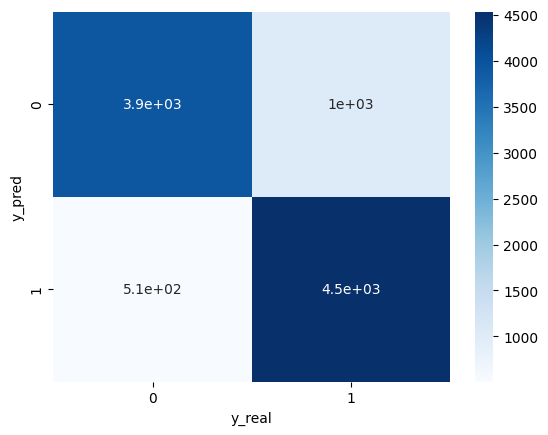

In [9]:
ds_validacion=pd.DataFrame(y_predic_cat,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

## Predicciones

In [10]:
X_conjunto_test = conjunto_test_processed.copy()
X_conjunto_test_array = np.array(X_conjunto_test, dtype=object).reshape(-1,1)

y_predic = model.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

# Transformacion en DataFrame para respetar las consignas
final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,positivo
3,60003,positivo
4,60004,positivo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,negativo
8597,68597,negativo


## Exportaciones

In [11]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

model.save(f'Modelos/red_neuronal_{current_date}.h5')

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_{current_date}.csv", index=False)

## Mejora del modelo

### Intentamos con la lemmarizacion (2 Dense Layers)

In [12]:
X_train_list = X_train_processed.tolist()
X_test_list = X_test_processed.tolist()

X_train_array = np.array(X_train_list, dtype=object).reshape(-1,1)
X_test_array = np.array(X_test_list, dtype=object).reshape(-1,1)

In [13]:
def create_model(optimizer='adam', dense_length=64, learning_rate=0.001, rho=0.95, epsilon=1e-07, momentum=0.0, threshold=0.5):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, epsilon=epsilon)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate, rho=rho, epsilon=epsilon, momentum=momentum)
    elif optimizer == 'adadelta':
        opt = Adadelta(learning_rate=learning_rate, rho=rho, epsilon=epsilon)

    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(dense_length, activation='relu', kernel_regularizer='l2'),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[F1Score(threshold=threshold)])

    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

param_dist_adam = {
    'optimizer': ['adam'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'threshold': [0.4, 0.42, 0.45, 0.5]
}

param_dist_rmsprop = {
    'optimizer': ['rmsprop'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'momentum': [0.0, 0.2, 0.5],
    'threshold': [0.4, 0.42, 0.45, 0.5]
}

param_dist_adadelta = {
    'optimizer': ['adadelta'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'threshold': [0.4, 0.42, 0.45, 0.5]
}

# Combiner les grilles de paramètres
param_grid = [
    param_dist_adam,
    param_dist_rmsprop,
    param_dist_adadelta
]

def grid_search(X_train, y_train, X_val, y_val, param_grid, n_iter):
    best_score = -1
    best_params = None
    
    for param_dist in param_grid:
        for _ in range(n_iter):
            params = {key: random.choice(value) for key, value in param_dist.items()}
            print(f"Testing parameters: {params}")

            model = create_model(**params)
            
            model.fit(
                X_train, y_train, 
                epochs=50, 
                batch_size=128, 
                validation_data=(X_val, y_val), 
                callbacks=callbacks_list
            )
            
            val_predictions = model.predict(X_val)
            val_predictions_cat = np.where(val_predictions>0.4,1,0)
            val_predictions_series = pd.Series(val_predictions_cat.flatten(), index=y_val.index)

            val_f1 = f1_score(y_val, val_predictions_series)
            print(f"F1-Score : {val_f1}")
            
            if val_f1 > best_score:
                best_score = val_f1
                best_params = params
        
            model = None
            
    return best_score, best_params

best_score, best_params = grid_search(X_train_array, y_train, X_test_array, y_test, param_grid, n_iter=20)

print("Best F1-Score: %f using %s" % (best_score, best_params))

Testing parameters: {'optimizer': 'adam', 'dense_length': 512, 'learning_rate': 0.0001, 'threshold': 0.42}
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 138ms/step - f1_score: 0.8043 - loss: 5.6687 - val_f1_score: 0.8815 - val_loss: 1.1491 - learning_rate: 1.0000e-04
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 136ms/step - f1_score: 0.9115 - loss: 0.8741 - val_f1_score: 0.8850 - val_loss: 0.6021 - learning_rate: 1.0000e-04
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - f1_score: 0.9221 - loss: 0.4845 - val_f1_score: 0.8730 - val_loss: 0.5093 - learning_rate: 1.0000e-04
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - f1_score: 0.9231 - loss: 0.3917 - val_f1_score: 0.8835 - val_loss: 0.4580 - learning_rate: 1.0000e-04
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - f1_score: 0.9204 - loss: 0.3661 - val_f1_score: 0.8768 - val_loss: 0.4619 - learning_rate: 1.0000e-04
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 134ms/step - f1_score: 0.9228 - loss: 0.3555 - val_f1_

In [14]:
if best_params['optimizer'] == 'rmsprop':
    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(best_params['dense_length'], activation='relu', kernel_regularizer='l2'),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])
    model.compile(
        optimizer=RMSprop(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon'], momentum=best_params['momentum']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adadelta':
    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(best_params['dense_length'], activation='relu', kernel_regularizer='l2'),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])
    model.compile(
        optimizer=Adadelta(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adam':
    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(best_params['dense_length'], activation='relu', kernel_regularizer='l2'),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])
    model.compile(
        optimizer=Adam(learning_rate=best_params['learning_rate']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

model.fit(X_train_array, y_train, epochs=50, batch_size=128, validation_data=(X_test_array, y_test), callbacks=callbacks_list)

Model: "sequential_121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_61           │ (None, 20000)          │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_303 (Dense)               │ (None, 512)            │    10,240,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_304 (Dense)               │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,241,025 (39.07 MB)

 Trainable params: 10,241,025 (39.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 132ms/step - f1_score: 0.8049 - loss: 5.7262 - val_f1_score: 0.8835 - val_loss: 1.1682 - learning_rate: 1.0000e-04
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - f1_score: 0.9153 - loss: 0.8911 - val_f1_score: 0.8797 - val_loss: 0.6197 - learning_rate: 1.0000e-04
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - f1_score: 0.9197 - loss: 0.4926 - val_f1_score: 0.8785 - val_loss: 0.5107 - learning_rate: 1.0000e-04
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 127ms/step - f1_score: 0.9211 - loss: 0.4035 - val_f1_score: 0.8832 - val_loss: 0.4597 - learning_rate: 1.0000e-04
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - f1_score: 0.9241 - loss: 0.3645 - val_f1_score: 0.8842 - val_loss: 0.4484 - learning_rate: 1.0000e-04
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - f1_score: 0.9246 - loss: 0.3521 - val_f1_score: 0.8798 - val_loss: 0.4414 - learning_rate: 1.0000e-04
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 13

In [15]:
y_predic = model.predict(X_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=y_test.index)

f1_score_modelo = f1_score(y_test, y_pred_series)
print(f"F1-Score del modelo de red neuronal: {f1_score_modelo}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
F1-Score del modelo de red neuronal: 0.8885289634146342


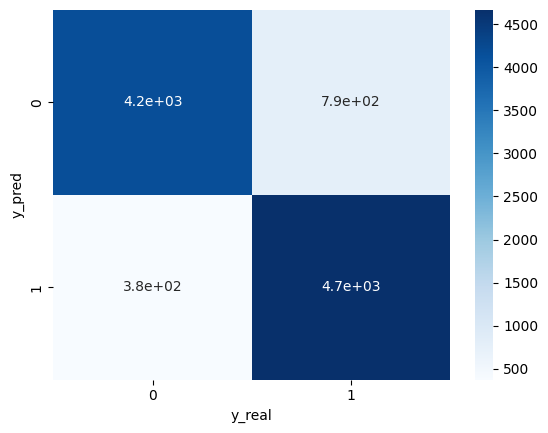

In [16]:
ds_validacion=pd.DataFrame(y_predic_cat,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [17]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_array = np.array(X_conjunto_test, dtype=object).reshape(-1,1)

y_predic = model.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


,ID,sentimiento
0,60000,positivo
1,60001,positivo
2,60002,positivo
3,60003,positivo
4,60004,positivo
...,...,...
8594,68594,positivo
8595,68595,positivo
8596,68596,positivo
8597,68597,negativo


In [18]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

model.save(f'Modelos/red_neuronal_lemmarizacion_{current_date}.h5')

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_lemmarizacion_{current_date}.csv", index=False)

### Intentamos con la lemmarizacion y Dropout layers

In [21]:
X_train_list = X_train_processed.tolist()
X_test_list = X_test_processed.tolist()

X_train_array = np.array(X_train_list, dtype=object).reshape(-1,1)
X_test_array = np.array(X_test_list, dtype=object).reshape(-1,1)

In [22]:
def create_model(optimizer='adam', dense_length=64, learning_rate=0.001, rho=0.95, epsilon=1e-07, momentum=0.0, threshold=0.5, max_tokens=10000, dropout_rate=0.5):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, epsilon=epsilon)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate, rho=rho, epsilon=epsilon, momentum=momentum)
    elif optimizer == 'adadelta':
        opt = Adadelta(learning_rate=learning_rate, rho=rho, epsilon=epsilon)

    vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=max_tokens)
    vectorizer.adapt(X_train_list)

    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(dense_length, activation='relu', kernel_regularizer='l2'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[F1Score(threshold=threshold)])

    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

param_dist_adam = {
    'optimizer': ['adam'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'max_tokens': [5000, 10000, 20000],
    'dropout_rate': [0.3, 0.4, 0.5, 0.6]
}

param_dist_rmsprop = {
    'optimizer': ['rmsprop'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'momentum': [0.0, 0.2, 0.5],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'max_tokens': [5000, 10000, 20000],
    'dropout_rate': [0.3, 0.4, 0.5, 0.6]
}

param_dist_adadelta = {
    'optimizer': ['adadelta'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'max_tokens': [5000, 10000, 20000],
    'dropout_rate': [0.3, 0.4, 0.5, 0.6]
}

# Combiner les grilles de paramètres
param_grid = [
    param_dist_adam,
    param_dist_rmsprop,
    param_dist_adadelta
]

def grid_search(X_train, y_train, X_val, y_val, param_grid, n_iter):
    best_score = -1
    best_params = None
    
    for param_dist in param_grid:
        for _ in range(n_iter):
            params = {key: random.choice(value) for key, value in param_dist.items()}
            print(f"Testing parameters: {params}")

            model = create_model(**params)
            
            model.fit(
                X_train, y_train, 
                epochs=50, 
                batch_size=128, 
                validation_data=(X_val, y_val), 
                callbacks=callbacks_list
            )
            
            val_predictions = model.predict(X_val)
            val_predictions_cat = np.where(val_predictions>0.4,1,0)
            val_predictions_series = pd.Series(val_predictions_cat.flatten(), index=y_val.index)

            val_f1 = f1_score(y_val, val_predictions_series)
            print(f"F1-Score : {val_f1}")
            
            if val_f1 > best_score:
                best_score = val_f1
                best_params = params
        
            model = None
            
    return best_score, best_params

best_score, best_params = grid_search(X_train_array, y_train, X_test_array, y_test, param_grid, n_iter=20)

print("Best F1-Score: %f using %s" % (best_score, best_params))

Testing parameters: {'optimizer': 'adam', 'dense_length': 16, 'learning_rate': 0.001, 'threshold': 0.4, 'max_tokens': 10000, 'dropout_rate': 0.6}
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - f1_score: 0.7284 - loss: 0.7200 - val_f1_score: 0.8633 - val_loss: 0.4785 - learning_rate: 0.0010
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - f1_score: 0.8362 - loss: 0.5269 - val_f1_score: 0.8737 - val_loss: 0.4799 - learning_rate: 0.0010
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - f1_score: 0.8416 - loss: 0.5139 - val_f1_score: 0.8700 - val_loss: 0.4755 - learning_rate: 0.0010
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - f1_score: 0.8459 - loss: 0.5103 - val_f1_score: 0.8688 - val_loss: 0.4813 - learning_rate: 0.0010
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - f1_score: 0.8426 - loss: 0.5193 - val_f1_score: 0.8690 - val_loss: 0.4708 - learning_rate: 0.0010
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - f1_score: 0.8429 - loss: 0.5119 -

In [23]:
vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=best_params['max_tokens'])
vectorizer.adapt(X_train_list)

model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Dense(best_params['dense_length'], activation='relu', kernel_regularizer='l2'),
    Dropout(best_params['dropout_rate']),
    Dense(1, activation='sigmoid', kernel_regularizer='l2')
])

if best_params['optimizer'] == 'rmsprop':
    model.compile(
        optimizer=RMSprop(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon'], momentum=best_params['momentum']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adadelta':
    model.compile(
        optimizer=Adadelta(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adam':
    model.compile(
        optimizer=Adam(learning_rate=best_params['learning_rate']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

model.fit(X_train_array, y_train, epochs=50, batch_size=128, validation_data=(X_test_array, y_test), callbacks=callbacks_list)

Model: "sequential_182"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_122          │ (None, 10000)          │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_425 (Dense)               │ (None, 16)             │       160,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_182 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_426 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,033 (625.13 KB)

 Trainable params: 160,033 (625.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - f1_score: 0.7366 - loss: 0.7422 - val_f1_score: 0.8668 - val_loss: 0.5026 - learning_rate: 0.0010
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - f1_score: 0.8441 - loss: 0.5318 - val_f1_score: 0.8725 - val_loss: 0.4942 - learning_rate: 0.0010
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - f1_score: 0.8525 - loss: 0.5186 - val_f1_score: 0.8706 - val_loss: 0.4962 - learning_rate: 0.0010
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - f1_score: 0.8517 - loss: 0.5199 - val_f1_score: 0.8584 - val_loss: 0.5106 - learning_rate: 0.0010
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - f1_score: 0.8546 - loss: 0.5200 - val_f1_score: 0.8764 - val_loss: 0.4993 - learning_rate: 0.0010
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - f1_score: 0.8622 - loss: 0.4914 - val_f1_score: 0.8738 - val_loss: 0.4454 - learning_rate: 2.0000e-04
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - f1_score: 0.8731 - lo

In [24]:
y_predic = model.predict(X_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=y_test.index)

f1_score_modelo = f1_score(y_test, y_pred_series)
print(f"F1-Score del modelo de red neuronal: {f1_score_modelo}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
F1-Score del modelo de red neuronal: 0.8879557167398359


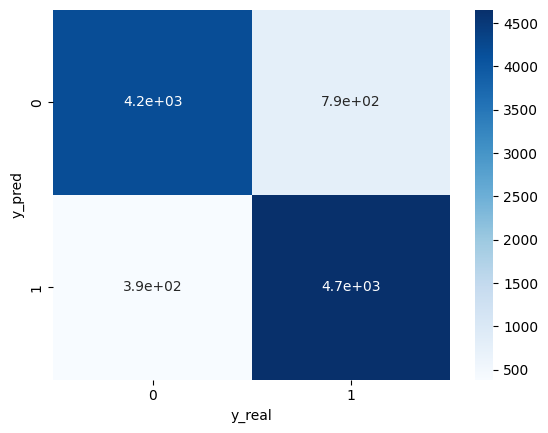

In [25]:
ds_validacion=pd.DataFrame(y_predic_cat,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [26]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_array = np.array(X_conjunto_test, dtype=object).reshape(-1,1)

y_predic = model.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,negativo
8597,68597,negativo


In [27]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

model.save(f'Modelos/red_neuronal_lemmarizacion_dropout_dense_{current_date}.h5')

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_lemmarizacion_dropout_dense_{current_date}.csv", index=False)

### Poner mas hiperparametros optimizados

In [4]:
X_train_list = X_train_processed.tolist()
X_test_list = X_test_processed.tolist()

X_train_array = np.array(X_train_list, dtype=object).reshape(-1,1)
X_test_array = np.array(X_test_list, dtype=object).reshape(-1,1)

In [6]:
def create_model(optimizer='adam', dense_length=64, learning_rate=0.001, rho=0.95, epsilon=1e-07, momentum=0.0, threshold=0.5, epochs=10, batch_size=32, max_tokens=10000):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, epsilon=epsilon)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate, rho=rho, epsilon=epsilon, momentum=momentum)
    elif optimizer == 'adadelta':
        opt = Adadelta(learning_rate=learning_rate, rho=rho, epsilon=epsilon)

    vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=max_tokens)
    vectorizer.adapt(X_train_list)

    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(dense_length, activation='relu', kernel_regularizer='l2'),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[F1Score(threshold=threshold)])

    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

param_dist_adam = {
    'optimizer': ['adam'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'batch_size': [32, 64, 128, 256],
    'epochs': [10, 20, 50, 100],
    'max_tokens': [5000, 10000, 20000]
}

param_dist_rmsprop = {
    'optimizer': ['rmsprop'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'momentum': [0.0, 0.2, 0.5],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'batch_size': [32, 64, 128, 256],
    'epochs': [10, 20, 50, 100],
    'max_tokens': [5000, 10000, 20000]
}

param_dist_adadelta = {
    'optimizer': ['adadelta'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'batch_size': [32, 64, 128, 256],
    'epochs': [10, 20, 50, 100],
    'max_tokens': [5000, 10000, 20000]
}

# Combiner les grilles de paramètres
param_grid = [
    param_dist_adam,
    param_dist_rmsprop,
    param_dist_adadelta
]

def grid_search(X_train, y_train, X_val, y_val, param_grid, n_iter):
    best_score = -1
    best_params = None
    
    for param_dist in param_grid:
        for _ in range(n_iter):
            params = {key: random.choice(value) for key, value in param_dist.items()}
            print(f"Testing parameters: {params}")

            model = create_model(**params)
            
            model.fit(
                X_train, y_train, 
                epochs=params['epochs'], 
                batch_size=params['batch_size'], 
                validation_data=(X_val, y_val), 
                callbacks=callbacks_list
            )
            
            val_predictions = model.predict(X_val)
            val_predictions_cat = np.where(val_predictions>val_predictions.flatten().mean(),1,0)
            val_predictions_series = pd.Series(val_predictions_cat.flatten(), index=y_val.index)

            val_f1 = f1_score(y_val, val_predictions_series)
            print(f"F1-Score : {val_f1}")
            
            if val_f1 > best_score:
                best_score = val_f1
                best_params = params
        
            model = None
            
    return best_score, best_params

best_score, best_params = grid_search(X_train_array, y_train, X_test_array, y_test, param_grid, n_iter=30)

print("Best F1-Score: %f using %s" % (best_score, best_params))

Testing parameters: {'optimizer': 'adam', 'dense_length': 512, 'learning_rate': 0.0001, 'threshold': 0.45, 'batch_size': 128, 'epochs': 10, 'max_tokens': 5000}
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - f1_score: 0.7388 - loss: 7.0472 - val_f1_score: 0.8753 - val_loss: 2.3133 - learning_rate: 1.0000e-04
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - f1_score: 0.8895 - loss: 1.8401 - val_f1_score: 0.8777 - val_loss: 1.0576 - learning_rate: 1.0000e-04
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - f1_score: 0.8943 - loss: 0.9010 - val_f1_score: 0.8761 - val_loss: 0.6875 - learning_rate: 1.0000e-04
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - f1_score: 0.8963 - loss: 0.6016 - val_f1_score: 0.8772 - val_loss: 0.5505 - learning_rate: 1.0000e-04
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - f1_score: 0.8983 - loss: 0.4812 - val_f1_score: 0.8718 - val_loss: 0.4842 - learning_rate: 1.0000e-04
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/s

In [8]:
vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=best_params['max_tokens'])
vectorizer.adapt(X_train_list)

model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Dense(best_params['dense_length'], activation='relu', kernel_regularizer='l2'),
    Dense(1, activation='sigmoid', kernel_regularizer='l2')
])

if best_params['optimizer'] == 'rmsprop':
    model.compile(
        optimizer=RMSprop(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon'], momentum=best_params['momentum']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adadelta':
    model.compile(
        optimizer=Adadelta(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adam':
    model.compile(
        optimizer=Adam(learning_rate=best_params['learning_rate']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

model.fit(X_train_array, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_test_array, y_test), callbacks=callbacks_list)

Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_90           │ (None, 20000)          │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 32)             │       640,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,065 (2.44 MB)

 Trainable params: 640,065 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - f1_score: 0.7578 - loss: 0.8811 - val_f1_score: 0.8893 - val_loss: 0.4936 - learning_rate: 1.0000e-04
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - f1_score: 0.9192 - loss: 0.4213 - val_f1_score: 0.8913 - val_loss: 0.4266 - learning_rate: 1.0000e-04
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - f1_score: 0.9317 - loss: 0.3427 - val_f1_score: 0.8870 - val_loss: 0.4035 - learning_rate: 1.0000e-04
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - f1_score: 0.9384 - loss: 0.3117 - val_f1_score: 0.8863 - val_loss: 0.3956 - learning_rate: 1.0000e-04
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - f1_score: 0.9403 - loss: 0.2946 - val_f1_score: 0.8814 - val_loss: 0.3970 - learning_rate: 1.0000e-04
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - f1_score: 0.9405 - loss: 0.2895 - val_f1_score: 0.8906 - val_loss: 0.3936 - learning_rate: 1.0000e-04
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/ste

In [9]:
y_predic = model.predict(X_test_array)
y_predic_cat = np.where(y_predic>y_predic.flatten().mean(),1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=y_test.index)

f1_score_modelo = f1_score(y_test, y_pred_series)
print(f"F1-Score del modelo de red neuronal: {f1_score_modelo}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
F1-Score del modelo de red neuronal: 0.8873740367516301


In [10]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_array = np.array(X_conjunto_test, dtype=object).reshape(-1,1)

y_predic = model.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>y_predic.flatten().mean(),1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,positivo
3,60003,positivo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,negativo
8597,68597,negativo


In [11]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

model.save(f'Modelos/red_neuronal_lemmarizacion_hiperparametros_{current_date}.h5')

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_lemmarizacion_hiperparametros_{current_date}.csv", index=False)

### Intentamos con LSTM y Embedding

In [7]:
X_train_list = X_train_processed.tolist()
X_test_list = X_test_processed.tolist()

X_train_array = np.array(X_train_list, dtype=object).reshape(-1,1)
X_test_array = np.array(X_test_list, dtype=object).reshape(-1,1)

In [75]:
def create_model(optimizer='adam', learning_rate=0.001, rho=0.95, epsilon=1e-07, momentum=0.0, threshold=0.5, max_tokens=10000, dropout_rate=0.5, embedding_dim=100, dense_length=64):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, epsilon=epsilon)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate, rho=rho, epsilon=epsilon, momentum=momentum)
    elif optimizer == 'adadelta':
        opt = Adadelta(learning_rate=learning_rate, rho=rho, epsilon=epsilon)

    vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=max_tokens)
    vectorizer.adapt(X_train_list)

    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dropout(dropout_rate),
        Dense(dense_length, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[F1Score(threshold=threshold)])

    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

param_dist_adam = {
    'optimizer': ['adam'],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'max_tokens': [5000, 10000, 20000],
    'dropout_rate': [0.3, 0.4, 0.5, 0.6],
    'dense_length': [32, 64, 128]
}

param_dist_rmsprop = {
    'optimizer': ['rmsprop'],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'momentum': [0.0, 0.2, 0.5],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'max_tokens': [5000, 10000, 20000],
    'dropout_rate': [0.3, 0.4, 0.5, 0.6],
    'dense_length': [32, 64, 128]
}

param_dist_adadelta = {
    'optimizer': ['adadelta'],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'max_tokens': [5000, 10000, 20000],
    'dropout_rate': [0.3, 0.4, 0.5, 0.6],
    'dense_length': [32, 64, 128]
}

param_grid = [
    param_dist_adam,
    param_dist_rmsprop,
    param_dist_adadelta
]

def grid_search(X_train, y_train, X_val, y_val, param_grid, n_iter):
    best_score = -1
    best_params = None
    
    for param_dist in param_grid:
        for _ in range(n_iter):
            params = {key: random.choice(value) for key, value in param_dist.items()}
            print(f"Testing parameters: {params}")

            model = create_model(**params)
            
            model.fit(
                X_train, y_train, 
                epochs=50, 
                batch_size=128, 
                validation_data=(X_val, y_val), 
                callbacks=callbacks_list
            )
            
            val_predictions = model.predict(X_val)
            val_predictions_cat = np.where(val_predictions>0.4,1,0)
            val_predictions_series = pd.Series(val_predictions_cat.flatten(), index=y_val.index)

            val_f1 = f1_score(y_val, val_predictions_series)
            print(f"F1-Score : {val_f1}")
            
            if val_f1 > best_score:
                best_score = val_f1
                best_params = params
        
            model = None
            
    return best_score, best_params

best_score, best_params = grid_search(X_train_array, y_train, X_test_array, y_test, param_grid, n_iter=50)

print("Best F1-Score: %f using %s" % (best_score, best_params))

Testing parameters: {'optimizer': 'adam', 'learning_rate': 0.0005, 'threshold': 0.4, 'max_tokens': 20000, 'dropout_rate': 0.4, 'dense_length': 32}
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 75ms/step - f1_score: 0.7329 - loss: 0.6096 - val_f1_score: 0.8777 - val_loss: 0.3479 - learning_rate: 5.0000e-04
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - f1_score: 0.8610 - loss: 0.3607 - val_f1_score: 0.8859 - val_loss: 0.3116 - learning_rate: 5.0000e-04
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - f1_score: 0.8803 - loss: 0.3103 - val_f1_score: 0.8870 - val_loss: 0.3027 - learning_rate: 5.0000e-04
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - f1_score: 0.8915 - loss: 0.2862 - val_f1_score: 0.8886 - val_loss: 0.2991 - learning_rate: 5.0000e-04
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - f1_score: 0.8964 - loss: 0.2657 - val_f1_score: 0.8880 - val_loss: 0.2985 - learning_rate: 5.0000e-04
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - f1_scor

In [9]:
vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=best_params['max_tokens'])
vectorizer.adapt(X_train_list)

model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Dropout(best_params['dropout_rate']),
    Dense(best_params['dense_length'], activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(1, activation='sigmoid', kernel_regularizer='l2')
])

if best_params['optimizer'] == 'rmsprop':
    model.compile(
        optimizer=RMSprop(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon'], momentum=best_params['momentum']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adadelta':
    model.compile(
        optimizer=Adadelta(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adam':
    model.compile(
        optimizer=Adam(learning_rate=best_params['learning_rate']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

model.fit(X_train_array, y_train, epochs=50, batch_size=128, validation_data=(X_test_array, y_test), callbacks=callbacks_list)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 20000)          │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       640,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,065 (2.44 MB)

 Trainable params: 640,065 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - f1_score: 0.7346 - loss: 0.6039 - val_f1_score: 0.8768 - val_loss: 0.3430 - learning_rate: 5.0000e-04
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - f1_score: 0.8632 - loss: 0.3491 - val_f1_score: 0.8832 - val_loss: 0.3113 - learning_rate: 5.0000e-04
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - f1_score: 0.8782 - loss: 0.3078 - val_f1_score: 0.8877 - val_loss: 0.3005 - learning_rate: 5.0000e-04
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - f1_score: 0.8904 - loss: 0.2753 - val_f1_score: 0.8821 - val_loss: 0.3005 - learning_rate: 5.0000e-04
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - f1_score: 0.8976 - loss: 0.2651 - val_f1_score: 0.8891 - val_loss: 0.2934 - learning_rate: 5.0000e-04
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - f1_score: 0.8993 - loss: 0.2521 - val_f1_score: 0.8863 - val_loss: 0.2994 - learning_rate: 5.0000e-04
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step 

In [10]:
y_predic = model.predict(X_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=y_test.index)

f1_score_modelo = f1_score(y_test, y_pred_series)
print(f"F1-Score del modelo de red neuronal: {f1_score_modelo}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
F1-Score del modelo de red neuronal: 0.8891002472893286


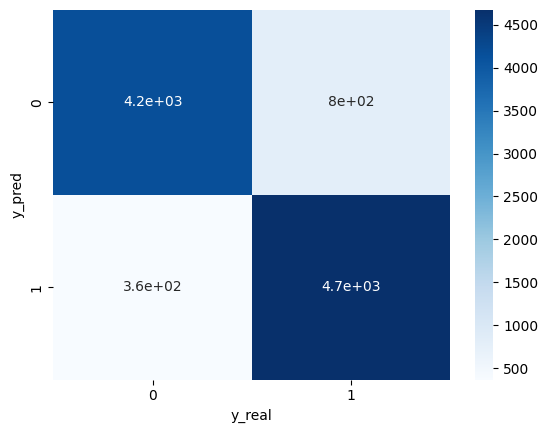

In [11]:
ds_validacion=pd.DataFrame(y_predic_cat,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [14]:
X_conjunto_test = conjunto_test_processed.copy()
X_conjunto_test_array = np.array(X_conjunto_test, dtype=object).reshape(-1,1)

y_predic = model.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test_processed.index,
    'sentimiento': pred_test_labels
})
final_pred_df

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,positivo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


In [15]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

model.save(f'Modelos/red_neuronal_lemmarizacion_recurrent_{current_date}.h5')

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_lemmarizacion_recurrent_{current_date}.csv", index=False)

## Correciones

### Lemmarizacion del conjunto de test

In [30]:
model = load_model('Modelos/red_neuronal_lemmarizacion_2024-06-15.h5')
conjunto_test = pd.read_csv('Datasets/conjunto_test_processed.csv', index_col=0)
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_array = np.array(X_conjunto_test, dtype=object).reshape(-1,1)

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_train_list = X_train_processed.tolist()

text_vectorization_layer = model.layers[0]
text_vectorization_layer.adapt(X_train_list)

y_predic = model.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_lemmarizacion_2024-06-15_v2.csv", index=False)

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [31]:
model = load_model('Modelos/red_neuronal_lemmarizacion_1_dense_2024-06-15.h5')
conjunto_test = pd.read_csv('Datasets/conjunto_test_processed.csv', index_col=0)
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_array = np.array(X_conjunto_test, dtype=object).reshape(-1,1)

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_train_list = X_train_processed.tolist()

text_vectorization_layer = model.layers[0]
text_vectorization_layer.adapt(X_train_list)

y_predic = model.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_lemmarizacion_1_dense_2024-06-15_v2.csv", index=False)

269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [32]:
model = load_model('Modelos/red_neuronal_lemmarizacion_2024-06-17.h5')
conjunto_test = pd.read_csv('Datasets/conjunto_test_processed.csv', index_col=0)
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_array = np.array(X_conjunto_test, dtype=object).reshape(-1,1)

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_train_list = X_train_processed.tolist()

text_vectorization_layer = model.layers[0]
text_vectorization_layer.adapt(X_train_list)

y_predic = model.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_lemmarizacion_2024-06-17_v2.csv", index=False)

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [33]:
model = load_model('Modelos/red_neuronal_lemmarizacion_dropout_dense_2024-06-17.h5')
conjunto_test = pd.read_csv('Datasets/conjunto_test_processed.csv', index_col=0)
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_array = np.array(X_conjunto_test, dtype=object).reshape(-1,1)

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_train_list = X_train_processed.tolist()

text_vectorization_layer = model.layers[0]
text_vectorization_layer.adapt(X_train_list)

y_predic = model.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_lemmarizacion_dropout_dense_2024-06-17_v2.csv", index=False)

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [34]:
model = load_model('Modelos/red_neuronal_lemmarizacion_dropout_dense_2024-06-18.h5')
conjunto_test = pd.read_csv('Datasets/conjunto_test_processed.csv', index_col=0)
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_array = np.array(X_conjunto_test, dtype=object).reshape(-1,1)

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_train_list = X_train_processed.tolist()

text_vectorization_layer = model.layers[0]
text_vectorization_layer.adapt(X_train_list)

y_predic = model.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_lemmarizacion_dropout_dense_2024-06-18_v2.csv", index=False)

269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [35]:
model = load_model('Modelos/red_neuronal_lemmarizacion_hiperparametros_2024-06-18.h5')
conjunto_test = pd.read_csv('Datasets/conjunto_test_processed.csv', index_col=0)
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_array = np.array(X_conjunto_test, dtype=object).reshape(-1,1)

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_train_list = X_train_processed.tolist()

text_vectorization_layer = model.layers[0]
text_vectorization_layer.adapt(X_train_list)

y_predic = model.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_lemmarizacion_hiperparametros_2024-06-18_v2.csv", index=False)

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


# 5. Ensamble de 3 modelos (o mas)

## Importaciones

In [14]:
# Tomando los ultimos y los mejores (que no es el ultimo) de cada modelo

ultimo_nb_model = joblib.load('Modelos/bn_model_2024-06-15.joblib')
mejor_nb_model = joblib.load('Modelos/bn_model_2024-05-31.joblib')

if hasattr(ultimo_nb_model, 'force_alpha') and ultimo_nb_model.force_alpha not in [True, False]:
    ultimo_nb_model.force_alpha = True
if hasattr(mejor_nb_model, 'force_alpha') and mejor_nb_model.force_alpha not in [True, False]:
    mejor_nb_model.force_alpha = True

ultimo_xgb_model = joblib.load('Modelos/xgb_model_2024-06-15.joblib')
mejor_xgb_model = joblib.load('Modelos/xgb_model_2024-05-28.joblib')

ultimo_rf_model = joblib.load('Modelos/rf_model_2024-06-15.joblib')
mejor_rf_model = joblib.load('Modelos/rf_model_2024-06-15.joblib')

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultinomialNB from version 1.2.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


NameError: name 'KerasClassifier' is not defined

In [33]:
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

## Voting

### Creacion del Ensamble

In [16]:
f1_scores = {
    'ultimo nb': 0.74588,
    'mejor nb': 0.74840,
    'ultimo xgb': 0.70304,
    'mejor xgb': 0.71215,
    'ultimo rf': 0.68773,
    'mejor rf': 0.68773,
}

total_f1 = sum(f1_scores.values())
initial_weights = [score / total_f1 for score in f1_scores.values()]

# Crear el ensamble
ensemble = VotingClassifier(estimators=[
    ('ultimo nb', ultimo_nb_model),
    ('mejor nb', mejor_nb_model),
    ('ultimo xgb', ultimo_xgb_model),
    ('mejor xgb', mejor_xgb_model),
    ('ultimo rf', ultimo_rf_model),
    ('mejor rf', mejor_rf_model),
], voting='soft', weights=initial_weights)  # 'soft' para probabilidades, 'hard' para mayorías

vect = TfidfVectorizer(stop_words=stop_words_es)
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

# Ajustar el modelo de ensamble
ensemble.fit(X_train_vect, y_train)

KeyboardInterrupt: 

In [35]:
# Predicciones del ensamble
y_pred = ensemble.predict(X_test_vect)

# Evaluación
f1 = f1_score(y_test, y_pred)

print(f'F1-Score: {f1}')

F1-Score: 0.8866686257224018


### Conjunto Test

In [36]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vect.transform(conjunto_test['review_es'])

pred_test = ensemble.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


### Exportaciones

In [37]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/Ensamble_voting_{current_date}.csv", index=False)

joblib.dump(ensemble, f'Modelos/Ensamble_voting_{current_date}.joblib')

['Modelos/Ensamble_voting_2024-06-15.joblib']

### Intentamos con redes neuronales unicamente

In [16]:
class KerasVotingClassifier:
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights if weights is not None else [1] * len(models)

    def fit(self, X_train, y_train, X_train_list, X_test, y_test):
        for model in self.models:
            text_vectorization_layer = model.layers[0]
            text_vectorization_layer.adapt(X_train_list)

            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
            callbacks_list = [early_stopping, reduce_lr]

            model.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=[F1Score])
            model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=callbacks_list)
    
    def predict(self, X, X_list=None):
        prediction_list = []
        for model in self.models :
            text_vectorization_layer = model.layers[0]
            text_vectorization_layer.adapt(X_list)
            prediction_list.append(model.predict(X))
        
        predictions = np.array(prediction_list)

        avg_predictions = (np.average(predictions, axis=0, weights=self.weights) > 0.4).astype(int)

        weighted_sum = np.zeros(predictions[0].shape)
        for i in range(len(self.weights)):
            weighted_sum += self.weights[i] * (predictions[i] > 0.4).astype(int)
        majority_predictions = (weighted_sum > (sum(self.weights) / 2)).astype(int)
        
        return avg_predictions, majority_predictions

In [17]:
models = [
    load_model('Modelos/red_neuronal_2024-06-11.h5'),
    load_model('Modelos/red_neuronal_2024-06-14.h5'),
    load_model('Modelos/red_neuronal_2024-06-15.h5'),
    load_model('Modelos/red_neuronal_2024-06-17.h5')
]

models_lemm = [
    load_model('Modelos/red_neuronal_lemmarizacion_1_dense_2024-06-15.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_2024-06-15.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_2024-06-17.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_dropout_1_dense_2024-06-22.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_dropout_dense_2024-06-17.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_dropout_dense_2024-06-18.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_hiperparametros_2024-06-18.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_recurrent_2024-06-23.h5')
]

X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

In [18]:
X_train_list = X_train.tolist()
X_test_list = X_test.tolist()

X_train_array = np.array(X_train_list, dtype=object).reshape(-1,1)
X_test_array = np.array(X_test_list, dtype=object).reshape(-1,1)

X_train_lemm_list = X_train_processed.tolist()
X_test_lemm_list = X_test_processed.tolist()

X_train_lemm_array = np.array(X_train_lemm_list, dtype=object).reshape(-1,1)
X_test_lemm_array = np.array(X_test_lemm_list, dtype=object).reshape(-1,1)

In [19]:
f1_scores = {
    'keras1': 0.76584,
    'keras2': 0.75789,
    'keras3': 0.75770,
    'keras4': 0.75596,
}

f1_scores_lemm = {
    'keras1': 0.77263,
    'keras2': 0.75751,
    'keras3': 0.76371,
    'keras4': 0.77863,
    'keras5': 0.74704,
    'keras6': 0.76235,
    'keras7': 0.75247,
    'keras8': 0.77127
}

total_f1 = sum(f1_scores.values())
initial_weights = [score / total_f1 for score in f1_scores.values()]

total_f1_lemm = sum(f1_scores_lemm.values())
initial_weights_lemm = [score / total_f1_lemm for score in f1_scores_lemm.values()]

voting_classifier = KerasVotingClassifier(models=models, weights=initial_weights)
voting_classifier.fit(X_train_array, y_train, X_train_list, X_test_array, y_test)

voting_classifier_lemm = KerasVotingClassifier(models=models_lemm, weights=initial_weights_lemm)
voting_classifier_lemm.fit(X_train_lemm_array, y_train, X_train_lemm_list, X_test_lemm_array, y_test)

# Predicciones del ensamble
y_pred_avg, y_pred_maj = voting_classifier.predict(X_test_array, X_train_list)
y_pred_avg_lemm, y_pred_maj_lemm = voting_classifier_lemm.predict(X_test_lemm_array, X_train_lemm_list)

# Evaluación
f1_avg = f1_score(y_test, y_pred_avg)
f1_maj = f1_score(y_test, y_pred_maj)
if f1_avg > f1_maj:
    mejor = "avg"
else :
    mejor = "maj"

print(f'F1-Score - Promedio: {f1_avg}')
print(f'F1-Score - Mayoria: {f1_maj}')

f1_avg_lemm = f1_score(y_test, y_pred_avg_lemm)
f1_maj_lemm = f1_score(y_test, y_pred_maj_lemm)
if f1_avg_lemm > f1_maj_lemm:
    mejor_lemm = "avg"
else :
    mejor_lemm = "maj"

print(f'F1-Score - Promedio - Lemmatizacion: {f1_avg_lemm}')
print(f'F1-Score - Mayoria - Lemmatizacion: {f1_maj_lemm}')

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - f1_score: 0.6668 - loss: 0.6902 - val_f1_score: 0.6714 - val_loss: 0.7425 - learning_rate: 0.0050
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - f1_score: 0.6679 - loss: 0.7227 - val_f1_score: 0.6711 - val_loss: 0.9697 - learning_rate: 0.0050
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - f1_score: 0.6675 - loss: 0.7738 - val_f1_score: 0.6722 - val_loss: 0.7758 - learning_rate: 0.0050
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - f1_score: 0.6643 - loss: 0.7398 - val_f1_score: 0.6718 - val_loss: 0.7608 - learning_rate: 0.0050
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - f1_score: 0.6687 - loss: 0.5796 - val_f1_score: 0.6703 - val_loss: 0.4296 - learning_rate: 1.0000e-03
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - f1_score: 0.6675 - loss: 0.3648 - val_f1_score: 0.6703 - val_loss: 0.4094 - learning_rate: 1.0000e-03
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - f1_score: 0.

In [20]:
conjunto_test = pd.read_csv('Datasets/test.csv')
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_list = X_conjunto_test.tolist()

conjunto_test_lemm = pd.read_csv('Datasets/conjunto_test_processed.csv', index_col=0)
X_conjunto_test_lemm = conjunto_test_lemm['review_es']
X_conjunto_test_list_lemm = X_conjunto_test_lemm.tolist()

pred_test_avg, pred_test_maj = voting_classifier.predict(X_conjunto_test, X_conjunto_test_list)
pred_test_avg_lemm, pred_test_maj_lemm = voting_classifier_lemm.predict(X_conjunto_test_lemm, X_conjunto_test_list_lemm)

if mejor == "avg":
    pred_test = pred_test_avg
else :
    pred_test = pred_test_maj

if mejor_lemm == "avg":
    pred_test_lemm = pred_test_avg_lemm
else :
    pred_test_lemm = pred_test_maj_lemm

pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]
pred_test_labels_lemm = ['positivo' if pred == 1 else 'negativo' for pred in pred_test_lemm]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})

final_pred_df_lemm = pd.DataFrame({
    'ID': conjunto_test_lemm.index,
    'sentimiento': pred_test_labels_lemm
})

269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [21]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/Ensamble_voting_redes_neuronales_{current_date}.csv", index=False)
final_pred_df_lemm.to_csv(f"Predicciones/Ensamble_voting_redes_neuronales_lemmarizacion_{current_date}.csv", index=False)

## Stacking

### Creacion del ensamble

In [38]:
vect = TfidfVectorizer(stop_words=stop_words_es, min_df=2, ngram_range=(1,3))

X_train_vect = vect.fit_transform(X_train).astype('float32')
X_test_vect = vect.transform(X_test).astype('float32')

In [39]:
# Crear el ensamble
base_models = [
    ('ultimo nb', ultimo_nb_model),
    ('mejor nb', mejor_nb_model),
    ('ultimo xgb', ultimo_xgb_model),
    ('mejor xgb', mejor_xgb_model),
    ('ultimo rf', ultimo_rf_model),
    ('mejor rf', mejor_rf_model),
]

base_predictions_train = np.zeros((X_train_vect.shape[0], len(base_models)))
base_predictions_test = np.zeros((X_test_vect.shape[0], len(base_models)))

for i, (name, model) in enumerate(base_models):
    model.fit(X_train_vect, y_train)
    base_predictions_train[:, i] = cross_val_predict(model, X_train_vect, y_train, cv=5, method='predict_proba')[:, 1]
    base_predictions_test[:, i] = model.predict_proba(X_test_vect)[:, 1]

meta_learner = LogisticRegression(random_state=42)
meta_learner.fit(base_predictions_train, y_train)

final_predictions = meta_learner.predict(base_predictions_test)

# Evaluación
f1 = f1_score(y_test, final_predictions)

print(f'F1-Score: {f1}')

F1-Score: 0.8994176290593229


### Conjunto test

In [40]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vect.transform(conjunto_test['review_es'])

base_predictions_conjunto_test = np.zeros((X_conjunto_test.shape[0], len(base_models)))

for i, (name, model) in enumerate(base_models):
    base_predictions_conjunto_test[:, i] = model.predict_proba(X_conjunto_test)[:, 1]

pred_test = meta_learner.predict(base_predictions_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


### Exportaciones

In [41]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/Ensamble_stacking_{current_date}.csv", index=False)

joblib.dump(meta_learner, f'Modelos/Ensamble_stacking_{current_date}.joblib')

['Modelos/Ensamble_stacking_2024-06-16.joblib']

### Intentamos con redes neuronales

In [35]:
class KerasStackingClassifier:
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights if weights is not None else [1] * len(models)

    def fit(self, X_train, y_train, X_train_list):
        self.meta_learner = LogisticRegression(random_state=42)
        self.base_predictions_train = np.zeros((X_train.shape[0], len(self.models)))
        
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        for i, model in enumerate(self.models):
            text_vectorization_layer = model.layers[0]
            text_vectorization_layer.adapt(X_train_list)
            self.base_predictions_train[:, i] = model.predict(X_train).flatten()

        param_grid = {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['lbfgs', 'liblinear'],
            'penalty': ['l1', 'l2']
        }
        grid_search = GridSearchCV(self.meta_learner, param_grid, cv=5, scoring='f1')
        grid_search.fit(self.base_predictions_train, y_train)
        
        self.meta_learner = grid_search.best_estimator_
        self.meta_learner.fit(self.base_predictions_train, y_train)

    def predict(self, X_test, X_test_list):
        base_predictions_test = np.zeros((X_test.shape[0], len(self.models)))
        
        for i, model in enumerate(self.models):
            text_vectorization_layer = model.layers[0]
            text_vectorization_layer.adapt(X_test_list)
            base_predictions_test[:, i] = model.predict(X_test).flatten()

        final_predictions = self.meta_learner.predict(base_predictions_test)
        return final_predictions

In [36]:
models = [
    load_model('Modelos/red_neuronal_2024-06-11.h5'),
    load_model('Modelos/red_neuronal_2024-06-14.h5'),
    load_model('Modelos/red_neuronal_2024-06-15.h5'),
    load_model('Modelos/red_neuronal_2024-06-17.h5')
]

models_lemm = [
    load_model('Modelos/red_neuronal_lemmarizacion_1_dense_2024-06-15.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_2024-06-15.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_2024-06-17.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_dropout_1_dense_2024-06-22.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_dropout_dense_2024-06-17.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_dropout_dense_2024-06-18.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_hiperparametros_2024-06-18.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_recurrent_2024-06-23.h5')
]

X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

X_train_list = X_train.tolist()
X_test_list = X_test.tolist()

X_train_array = np.array(X_train_list, dtype=object).reshape(-1,1)
X_test_array = np.array(X_test_list, dtype=object).reshape(-1,1)

X_train_lemm_list = X_train_processed.tolist()
X_test_lemm_list = X_test_processed.tolist()

X_train_lemm_array = np.array(X_train_lemm_list, dtype=object).reshape(-1,1)
X_test_lemm_array = np.array(X_test_lemm_list, dtype=object).reshape(-1,1)

In [37]:
stacking_classifier = KerasStackingClassifier(models=models)
stacking_classifier.fit(X_train_array, y_train, X_train_list)

stacking_classifier_lemm = KerasStackingClassifier(models=models_lemm)
stacking_classifier_lemm.fit(X_train_lemm_array, y_train, X_train_lemm_list)

final_predictions = stacking_classifier.predict(X_test_array, X_test_list)
final_predictions_lemm = stacking_classifier_lemm.predict(X_test_lemm_array, X_test_lemm_list)

f1 = f1_score(y_test, final_predictions)
print(f'F1-Score: {f1}')

f1_lemm = f1_score(y_test, final_predictions_lemm)
print(f'F1-Score - Lemm: {f1_lemm}')

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step


c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\flaph\AppData\Local\Programs\Pyt

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step


c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
F1-Score: 0.8714159030446349
F1-Score - Lemm: 0.8756799525269509


In [38]:
conjunto_test = pd.read_csv('Datasets/test.csv')
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_list = X_conjunto_test.tolist()
X_conjunto_test_array = np.array(X_conjunto_test_list, dtype=object).reshape(-1, 1)

conjunto_test_lemm = pd.read_csv('Datasets/conjunto_test_processed.csv', index_col=0)
X_conjunto_test_lemm = conjunto_test_lemm['review_es']
X_conjunto_test_list_lemm = X_conjunto_test_lemm.tolist()
X_conjunto_test_array_lemm = np.array(X_conjunto_test_list_lemm, dtype=object).reshape(-1, 1)

pred_test = stacking_classifier.predict(X_conjunto_test_array, X_conjunto_test_list)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

pred_test_lemm = stacking_classifier_lemm.predict(X_conjunto_test_array_lemm, X_conjunto_test_list_lemm)
pred_test_labels_lemm = ['positivo' if pred == 1 else 'negativo' for pred in pred_test_lemm]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df_lemm = pd.DataFrame({
    'ID': conjunto_test_lemm.index,
    'sentimiento': pred_test_labels_lemm
})

269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [39]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/Ensamble_stacking_redes_neuronales_{current_date}.csv", index=False)
joblib.dump(stacking_classifier.meta_learner, f'Modelos/Ensamble_stacking_redes_neuronales_{current_date}.joblib')

final_pred_df_lemm.to_csv(f"Predicciones/Ensamble_stacking_redes_neuronales_lemmatizacion_{current_date}.csv", index=False)
joblib.dump(stacking_classifier_lemm.meta_learner, f'Modelos/Ensamble_stacking_redes_neuronales_lemmatizacion_{current_date}.joblib')

['Modelos/Ensamble_stacking_redes_neuronales_lemmatizacion_2024-06-24.joblib']

# Métricas de los modelos

## Bayes Naïve

In [41]:
model = joblib.load('Modelos/bn_model_2024-05-31.joblib')

X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

vectorizer = TfidfVectorizer(stop_words=stop_words_es, min_df=2, ngram_range=(1,4))
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)
y_pred = model.predict(X_test_vect)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultinomialNB from version 1.2.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Accuracy: 0.8871
Precision: 0.8756725595695619
Recall: 0.9043461004167493
F1 Score: 0.8897783852386996


## Random Forest

In [15]:
model = joblib.load('Modelos/rf_model_2024-06-02.joblib')

X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

vectorizer = TfidfVectorizer(stop_words=stop_words_es, min_df=2, ngram_range=(1,3))
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)
y_pred = model.predict(X_test_vect)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

ValueError: X has 749890 features, but RandomForestClassifier is expecting 88677 features as input.

## XGBoost

In [7]:
model = joblib.load('Modelos/xgb_model_lemmatizacion_2024-05-28.joblib')

X_test = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']
X_train = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

vectorizer = TfidfVectorizer(stop_words=stop_words_es, min_df=3, ngram_range=(1,4))
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)
y_pred = model.predict(X_test_vect)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

ValueError: Feature shape mismatch, expected: 132337, got 914351